In [25]:
# Bibliotheken
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.pyplot as plt

# LU-Zerlegung, relativer Fehler, Fehlerverstaerkungsfaktor

In [26]:
A = np.array([[8, -7, 2, 2], 
              [5, -2, 1, 0], 
              [2, -1, 1, 0], 
              [0, -2, 0, 1]], dtype=float)

b_not_exact = np.array([5, 4, 2, -1], dtype=float)
b_exact = np.array([5.03, 4.01, 2.02, -0.99], dtype=float)

# LU decomposition
P_T, L, U = sp.linalg.lu(A) # A = P_T @ L @ U
P = P_T.T # P = P_T_T

"""
LGS mit LU-Zerlegung loesen:

A @ x = b               <=>
P_T @ L @ U @ x = b     <=>
L @ U @ x = P @ b       <=>
L @ y = P @ b           <=>
U @ x = y               nach x aufloesen
"""

# solve A @ x = b_exact
y = sp.linalg.solve_triangular(L, P @ b_exact, lower=True) # L @ y = P @ b_exact nach y aufloesen
x_exact = sp.linalg.solve_triangular(U, y, lower=False) # U @ x_exact = y nach x_exact aufloesen
print(f"x_exact: {x_exact}")

# solve A @ x = b_not_exact
y = sp.linalg.solve_triangular(L, P @ b_not_exact, lower=True) # L @ y = P.T @ b_not_exact nach y aufloesen
x_not_exact = sp.linalg.solve_triangular(U, y, lower=False) # U @ x_not_exact = y nach x_not_exact aufloesen
print(f"x_not_exact: {x_not_exact}")

# Zaehler und Nenner fuer den relativen Fehler von x berechnen, resp. 1-norm von delta_x und 1-norm von x_exact
delta_x_norm = np.linalg.norm(x_exact - x_not_exact, ord=1) # 1-norm of delta_x
x_exact_norm = np.linalg.norm(x_exact, ord=1) # 1-norm of x_exact

# relativen Fehler von x berechnen
rel_error_x = delta_x_norm / x_exact_norm # relativer Fehler = delta_x_norm / x_exact_norm
print(f"relativer Fehler von x: {rel_error_x}")


# Verstaerkungsfaktor berechnen
"""
Verstaerkungsfaktor := relative Aenderung von x / relative Aenderung von b = rel_error_x / rel_error_b
"""

# dazu muessen wir zuerst den relativen Fehler von b berechnen
rel_error_b = np.linalg.norm(b_exact - b_not_exact, ord=1) / np.linalg.norm(b_exact, ord=1) # relativer Fehler von b
print(f"relativer Fehler von b: {rel_error_b}")

# Verstaerkungsfaktor berechnen
verstaerkungsfaktor = rel_error_x / rel_error_b
print(f"Verstaerkungsfaktor: {verstaerkungsfaktor}")

x_exact: [0.98 0.95 1.01 0.91]
x_not_exact: [1. 1. 1. 1.]
relativer Fehler von x: 0.04415584415584164
relativer Fehler von b: 0.0058091286307054
Verstaerkungsfaktor: 7.601113172541304


# LU-Zerlegung, Vor-, Rückwärtseinsetzen für Tridiagonalmatrizen

In [27]:
"""
LU decomposition for tridiagonal matrix
in: a  =  [[0,      a_{21}, ..., a_{n-1,n-2}, a_{n,n-1}],
           [a_{11}, a_{22}, ..., a_{n-1,n-1}, a_{nn}],
           [a_{12}, a_{23}, ..., a_{n-1,n},   0]]

out: LU = [[0,      l_{21}, ..., l_{n-1,n-2}, l_{n,n-1}],
           [r_{11}, r_{22}, ..., r_{n-1,n-1}, r_{nn}],
           [r_{12}, r_{23}, ..., r_{n-1,n},   0]]
"""
def LUT(a):
  
    n = np.shape(a)[1] # Anzahl Spalten
    LU = np.zeros_like(a) # Initialisierung
    
    LU[1][0] = a[1][0]
    for j in range(1,n):
        LU[0][j] = a[0][j]/LU[1][j-1]
        LU[2][j-1] = a[2][j-1]
        LU[1][j] = a[1][j] - LU[0][j]*LU[2][j-1]
        
    return LU


"""
in: LU (output from LUT), vector b
out: vector x such that L@U@x == b
"""  
def fbSubsT(LU, b):
    
    n = len(b)
    
    # Vorwärtseinsetzen:
    y = np.zeros_like(b)
    y[0] = b[0]
    
    for j in range(1, n):
        y[j] = b[j]-LU[0][j]*y[j-1]

    
    # Rückwärtseinsetzen:
    x = np.zeros_like(b)
    x[n-1] = y[n-1]/LU[1][n-1]
    
    for j in range(n-2,-1,-1):
        x[j] = (y[j]-x[j+1]*LU[2][j])/LU[1][j]
        
    return x

### Beispiel: Randwertproblem (Serie 14 Aufgabe 2)

In [28]:
def solveRWP(x0, xend, y0, yend, N):

    h = (xend - x0)/(N+1.0)
    x = np.linspace(x0, xend, N+2)
    y_ins = np.zeros(N)

    # create tridiagonal matrix
    upV = h**(-2) + 2/h
    midV = 8 - 2*h**(-2)
    lowV = h**(-2) - 2/h
    A = np.zeros((3, N))
    A[0, 1:] = lowV
    A[1, :] = midV
    A[2, :-1] = upV

    # create right hand side
    b = np.zeros(N)
    b[N-1] = -upV*yend

    # solve system with LU for tridiagonal matrices
    LU = LUT(A)
    y_ins = fbSubsT(LU, b)

    # add boundary values
    y_complete = np.zeros(N+2)
    y_complete[0] = y0
    y_complete[1:N+1] = y_ins
    y_complete[N+1] = yend
    
    return x, y_complete


x0 = 0.0
xend = 3.0
y0 = 0.0
yend = np.e**(-6.0)*np.sin(6.0)

# calculte maximum absolute error for N = 10^j, j = 1, ..., 6
for j in range(1, 7):
    n = 10**j
    x_sol, y_sol = solveRWP(x0, xend, y0, yend, n)
    print(f'N = {n}: ', np.max(np.abs(y_sol - np.e**(-2*x_sol)*np.sin(2*x_sol))))

N = 10:  3.024482492821329
N = 100:  0.006135937869705954
N = 1000:  6.155913959821069e-05
N = 10000:  6.165922525891432e-07
N = 100000:  5.971168393070769e-09
N = 1000000:  9.106846443618366e-09


# lineare Ausgleichsrechnung / Normalgleichung

In [29]:
#ueberbestimmtes LGS aufstellen
"""
ueberbestimmtes LGS: 
A @ alpha = u
"""

# gegeben aus Aufgabenstellung
t = np.array([0, 5, 10, 15, 20], dtype=float)
periode = 20.0
omega = 2 * np.pi / periode
u = np.array([-1.5, 1.5, 2.5, -0.5, -1.5]) # rechte Seite des LGS

# Matrix A mit Modellfunktionen und Datenpunkten aufstellen
A = np.zeros((5, 3), dtype=float)
for i in range(5):
    A[i, :] = np.array([1, np.cos(omega*t[i]), np.sin(omega*t[i])]) # Zeile i von A: [1, cos(t[i]), sin(t[i])]

print(f"A: \n{A}")
print(f"u: \n{u}")

A: 
[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  6.1232340e-17  1.0000000e+00]
 [ 1.0000000e+00 -1.0000000e+00  1.2246468e-16]
 [ 1.0000000e+00 -1.8369702e-16 -1.0000000e+00]
 [ 1.0000000e+00  1.0000000e+00 -2.4492936e-16]]
u: 
[-1.5  1.5  2.5 -0.5 -1.5]


### Variante 1: Cholesky von A.T @ A

In [30]:
# Normalgleichung aufstellen
"""
Normalgleichung: 
A.T @ A @ alpha = A.T @ u
"""

print(f"A.T @ A: \n{A.T @ A}")
print(f"\nA.T @ u: \n{A.T @ u}")


# Cholesky-Zerlegung von A.T @ A
C = sp.linalg.cholesky(A.T @ A, lower=True) # A.T @ A = C @ C^T
print(f"\n\nC: \n{C}")

# Normalgleichung mit Cholesky-Zerlegung loesen
"""
A.T @ A @ alpha = A.T @ u <=> 
C @ C.T @ alpha = A.T @ u

C @ y = A.T @ u nach y aufloesen 
C.T @ alpha = y nach alpha aufloesen
"""
y = sp.linalg.solve_triangular(C, A.T @ u, lower=True) # C @ y = A.T @ u nach y aufloesen
alpha = sp.linalg.solve_triangular(C.T, y, lower=False)  # C^T @ alpha = y nach alpha aufloesen
print(f"\nalpha: {alpha}")

A.T @ A: 
[[ 5.00000000e+00  1.00000000e+00 -2.28847549e-17]
 [ 1.00000000e+00  3.00000000e+00 -1.22464680e-16]
 [-2.28847549e-17 -1.22464680e-16  2.00000000e+00]]

A.T @ u: 
[ 0.5 -5.5  2. ]


C: 
[[ 2.23606798e+00  0.00000000e+00  0.00000000e+00]
 [ 4.47213595e-01  1.67332005e+00  0.00000000e+00]
 [-1.02343735e-17 -7.04513932e-17  1.41421356e+00]]

alpha: [ 0.5 -2.   1. ]


### Variante 2: (reduzierte) QR Zerlegung von A
-> A besser konditioniert als A^T @ A

In [31]:
# reduzierte (economic) QR-Zerlegung von A
Q, R = sp.linalg.qr(A, mode="economic") # A = Q @ R
print(f"\nQ:\n{Q}")
print(f"\nR:\n{R}")

# Normalgleichung mit reduzierter QR-Zerlegung loesen
alpha = sp.linalg.solve_triangular(R, Q.T @ u, lower=False) # R @ alpha = Q.T @ u nach alpha aufloesen
print(f"\nalpha: {alpha}")


Q:
[[-4.47213595e-01  4.78091444e-01 -2.35149010e-16]
 [-4.47213595e-01 -1.19522861e-01  7.07106781e-01]
 [-4.47213595e-01 -7.17137166e-01  3.15913018e-16]
 [-4.47213595e-01 -1.19522861e-01 -7.07106781e-01]
 [-4.47213595e-01  4.78091444e-01 -2.94709645e-16]]

R:
[[-2.23606798e+00 -4.47213595e-01  5.47678698e-17]
 [ 0.00000000e+00  1.67332005e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.41421356e+00]]

alpha: [ 0.5 -2.   1. ]


# nichtlineare Gleichungssysteme / Newton

In [32]:
# Newton's method for solving nonlinear systems
"""
Solve nonlinear system f(x)=0 by Newton's method.
J is the Jacobian of f. Both f and J must be functions of x.
At input, x holds the start value. 
The iteration continues until |f(x)| < tol or the max number of iterations is exceeded.
"""
def newton_solver(f, J, x, tol = 1e-10, max_iter = 100):
    for i in range(max_iter):
        if np.linalg.norm(f(x)) < tol:
            print('Found solution after',i,'iterations: x =',x,'\n')
            return x
        delta = np.linalg.solve(J(x), f(x))
        x = x - delta

    print('Exceeded maximum iterations. No solution found.\n')
    return None

### Beispiel (Serie 14 Aufgabe 4a)

start value: [1.5 0. ]
Found solution after 21 iterations: x = [-0.63523267 -1.13940323] 

start value: [1.21352549 0.88167788]
Found solution after 13 iterations: x = [-1.59575261  0.47622138] 

start value: [0.46352549 1.42658477]
Exceeded maximum iterations. No solution found.

start value: [-0.46352549  1.42658477]
Found solution after 11 iterations: x = [-1.59575261  0.47622138] 

start value: [-1.21352549  0.88167788]
Found solution after 5 iterations: x = [-1.59575261  0.47622138] 

start value: [-1.5000000e+00  1.8369702e-16]
Found solution after 5 iterations: x = [-1.59575261  0.47622138] 

start value: [-1.21352549 -0.88167788]
Found solution after 5 iterations: x = [-0.63523267 -1.13940323] 

start value: [-0.46352549 -1.42658477]
Found solution after 4 iterations: x = [-0.63523267 -1.13940323] 

start value: [ 0.46352549 -1.42658477]
Found solution after 5 iterations: x = [-0.63523267 -1.13940323] 

start value: [ 1.21352549 -0.88167788]
Found solution after 7 iterations: x

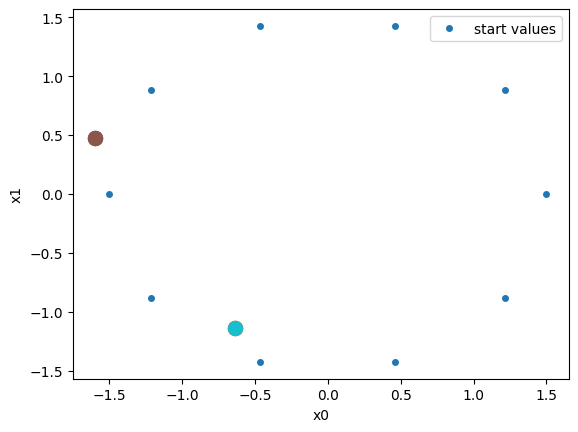

In [33]:
def f(x):
    return np.array([
        x[0]**2 + 2*x[1]**2 - 3,
        2*np.sin(x[0])*np.sin(x[1]-1)-1
    ])

def Df(x):
    return np.array([
        [2*x[0], 4*x[1]],
        [2*np.sin(x[1]-1)*np.cos(x[0]), 2*np.sin(x[0])*np.cos(x[1]-1)]
    ])

# both solutions are inside the circle with radius 2 => define 10 starting points on the circle with radius 1.5
xa = []
for k in range(10):
    xa.append(np.array([1.5*np.cos(k*2.0*np.pi/10.0), 1.5*np.sin(k*2.0*np.pi/10.0)]))
xa = np.array(xa)
solutions = []
for xak in xa:
    print('start value:', xak)
    solutions.append(newton_solver(f, Df, xak))

# plot solutions
plt.figure()
plt.plot(xa[:, 0], xa[:, 1], 'o', markersize=4, label='start values')
for sol in solutions:
    if sol is not None:
        plt.plot(sol[0], sol[1], 'o', markersize=10)
plt.legend()
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

# nichtlineare Ausgleichsrechnung / Gauss-Newton

In [34]:
"""
Minimize (least squares) nonlinear, overdetermined (m>n) system of equations described by F(alpha)=0.
J is the Jacobian of F. F and J must be functions of alpha.
At input, alpha holds the start value alpha0. 
The iteration continues until res = |grad(0.5*|F(alpha)|^2)| < tol, which implies we have found a local minimum.
"""
# Gauss Newton
def gauss_newton_solver(F, J, alpha0, max_iter=100, tol=1e-10, damped=False):
    alpha = np.copy(alpha0)
    for i in range(max_iter):
        res = np.linalg.norm(J(alpha).T@F(alpha)) # entspricht |grad(0.5*|F(alpha)|^2)| (Norm der Steigung am aktuellen Punkt in der Fehlerfunktion (Residuenquadratsumme))
        if res < tol:
            print('Found local minimum after',i,'iterations.')
            return alpha, res
        step = np.linalg.solve(J(alpha).T@J(alpha), -J(alpha).T@F(alpha))
        mu = 1.0
        mu_min = 0.05
        if damped:
            while np.linalg.norm(F(alpha + mu*step)) > np.linalg.norm(F(alpha)) and mu > mu_min:
                mu = mu/2.0
        alpha = alpha + mu*step 
        print(f'alpha after iteration {i+1}: {alpha}')
    print('Exceeded maximum iterations. No solution found.')  
    return None

### Beispiel (Serie 14 Aufgabe 13)

alpha after iteration 1: [ 0.07933087 -0.04330631 -1.93494659]
alpha after iteration 2: [ 0.07940436 -0.044858   -0.61573187]
alpha after iteration 3: [ 0.07082706 -0.03978557 -1.0667609 ]
alpha after iteration 4: [ 0.07779183 -0.05191423 -1.45032755]
alpha after iteration 5: [ 0.07950329 -0.05206021 -1.25291908]
alpha after iteration 6: [ 0.07901085 -0.05276281 -1.32688223]
alpha after iteration 7: [ 0.07926181 -0.05266778 -1.30493998]
alpha after iteration 8: [ 0.07919723 -0.0527182  -1.31177882]
alpha after iteration 9: [ 0.07921818 -0.05270445 -1.30969375]
alpha after iteration 10: [ 0.07921188 -0.05270883 -1.31033303]
alpha after iteration 11: [ 0.07921382 -0.0527075  -1.31013738]
alpha after iteration 12: [ 0.07921322 -0.05270791 -1.31019729]
alpha after iteration 13: [ 0.07921341 -0.05270779 -1.31017895]
Found local minimum after 13 iterations.

alpha: [ 0.07921341 -0.05270779 -1.31017895]


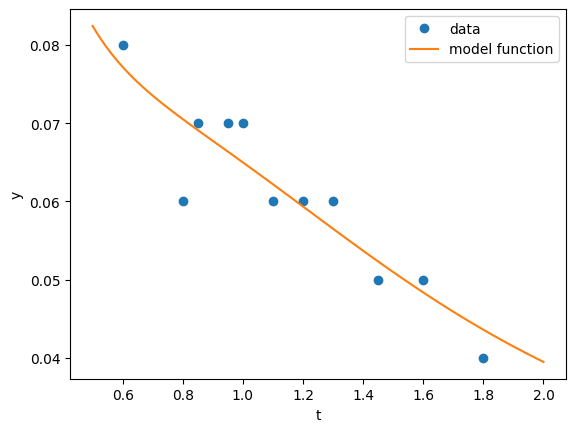

In [35]:
# data
t_data = np.array([0.6, 0.8, 0.85, 0.95, 1.0, 1.1, 1.2, 1.3, 1.45, 1.6, 1.8])
y_data = np.array([0.08, 0.06, 0.07, 0.07, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.04])

# model function
def phi(x, alpha):
    return alpha[0]/x + alpha[1]*np.exp(alpha[2]*(x**2))/x

# residual function
def F(alpha):
    return phi(t_data, alpha) - y_data

# Jacobian of residual function
def DF(alpha):
    return np.array([1/t_data, np.exp(alpha[2]*(t_data**2))/t_data, alpha[1]*t_data**2*np.exp(alpha[2]*(t_data**2))/t_data]).T

# initial guess
alpha0 = np.array([0.0, -1.0, -2.0])

# solve nonlinear least squares problem
alpha, res = gauss_newton_solver(F, DF, alpha0, tol=10.0**(-9), damped=True)
print(f"\nalpha: {alpha}")

# plot data and model function
t_plot = np.linspace(0.5, 2.0, 100)
plt.figure()
plt.plot(t_data, y_data, 'o', label='data')
plt.plot(t_plot, phi(t_plot, alpha), label='model function')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

# Butcher Tableau von verschiedenen Verfahren

In [36]:
# Butcher tableau for implicit Euler method
A_Ei = np.array([[1.0]], dtype=float)
b_Ei = np.array([1.0], dtype=float)
c_Ei = np.array([1.0], dtype=float)

# Butcher tableau for explicit Euler method
A_Ee = np.array([[0.0]], dtype=float)
b_Ee = np.array([1.0], dtype=float)
c_Ee = np.array([0.0], dtype=float)

# Butcher tableau for implicit midpoint method
A_Mi = np.array([[1/2]], dtype=float)
b_Mi = np.array([1.0], dtype=float) 
c_Mi = np.array([1/2], dtype=float)

# Butcher tableau for Heun's method
A_H = np.array([[0.0, 0.0],
                [1.0, 0.0]], dtype=float)
b_H = np.array([1/2, 1/2], dtype=float)
c_H = np.array([0.0, 1.0], dtype=float)

# Butcher tableau for RK2 method
A_RK2 = np.array([[0.0, 0.0],
                [1/2, 0.0]], dtype=float)
b_RK2 = np.array([0.0, 1.0], dtype=float)
c_RK2 = np.array([0.0, 1/2], dtype=float)

# Butcher tableau for the classical RK4 method
A_RK4 = np.array([[0.0, 0.0, 0.0, 0.0],
                [1/2, 0.0, 0.0, 0.0],
                [0.0, 1/2, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0]], dtype=float)
b_RK4 = np.array([1/6, 1/3, 1/3, 1/6], dtype=float)
c_RK4 = np.array([0.0, 1/2, 1/2, 1.0], dtype=float)

# Butcher tableau for the implicit trapezoidal method
A_Ti = np.array([[0.0, 0.0],
                [1/2, 1/2]], dtype=float)
b_Ti = np.array([1/2, 1/2], dtype=float)
c_Ti = np.array([0.0, 1.0], dtype=float)

# Butcher tableau for Hammer-Hollingsworth method
A_HH = np.array([[1/4, 1/4-np.sqrt(3)/6],
                [1/4+np.sqrt(3)/6, 1/4]], dtype=float)
b_HH = np.array([0.5, 0.5], dtype=float)
c_HH = np.array([(3-np.sqrt(3))/6, (3+np.sqrt(3))/6], dtype=float)

# Butcher tableau for Crouzeix method
A_C = np.array([[1/2+np.sqrt(3)/6, 0.0],
                [-np.sqrt(3)/3, 1/2+np.sqrt(3)/6]], dtype=float)
b_C = np.array([1/2, 1/2], dtype=float)
c_C = np.array([1/2+np.sqrt(3)/6, 1/2-np.sqrt(3)/6], dtype=float)

# allgemeines RK-Verfahren für eindimensionale ODE's
ERK (explicit), DIRK (diagonally implicit) und FIRK (fully implicit) Butcher Tableaus können übergeben werden.

In [37]:
"""
description:
    solves a first order ODE using a Runge-Kutta method specified by the Butcher tableau 
    
params:
    x0: start point of the interval
    xend: end point of the interval
    h: step size
    y0: initial value
    f: function f(x,y) = y'
    df: (diagonally) implicit methods require the derivative of f with respect to y (df(x,y)/dy), for explicit methods df is not needed and can (but doesn't have to) be set to None
    A: matrix of coefficients in Butcher tableau
    b: row vector at the bottom of Butcher tableau
    c: column vector at the left of Butcher tableau

returns:
    x: array of x values with step size h
    y: array of corresponding y values
"""
def RK(x0, xend, h, y0, f, df, A, b, c):
    x = [x0]
    y = [y0]

    s = len(c) # number of stages
    id = np.eye(s) # identity matrix of size s
    r = np.array([f(x[-1],y[-1])]*s) # initialize slopes



    # if method is explicit (ERK), we can sequentially compute the slopes in each stage:
    if np.allclose(A,np.tril(A, -1)):

        # loop over all time steps
        while x[-1] < xend-h/2:
            # loop over stages
            for i in range(s):
                r[i] = f(x[-1]+c[i]*h, y[-1]+h*(A[i,:i]@r[:i]))
            y.append(y[-1]+h*r@b)
            x.append(x[-1]+h)


    # if method is diagonally implicit (DIRK), we can sequentially compute the slopes in each stage using scalar Newton's method:
    elif np.allclose(A,np.tril(A)):

        # function for Newton's method
        def g(ri, xk, yk):
            res = ri - f(xk+c[i]*h, yk+h*(A[i,:i]@r[:i] + A[i,i]*ri))
            return res
        
        # derivative of g with respect to r
        def dg(ri, xk, yk):
            res = 1 - h*A[i,i]*df(xk+c[i]*h, yk+h*(A[i,:i]@r[:i] + A[i,i]*ri))
            return res

        # Newton's method for DIRK
        def newton_scalar(r, xk, yk, tol=1e-12, maxIter=20):
            k = 0
            delta = 10 * tol
            while np.abs(delta) > tol and k < maxIter:
                delta = g(r,xk,yk) / dg(r,xk,yk)
                r = r - delta
                k += 1
            return r
        
        # loop over all time steps
        while x[-1] < xend-h/2:
            # loop over stages
            for i in range(s):
                r[i] = newton_scalar(r[i], x[-1], y[-1]) # compute slope for stage i
            y.append(y[-1]+h*r@b)
            x.append(x[-1]+h)


    # if method is fully implicit (IRK), we need to solve a system of equations in each time step:
    else:
        
        # function for Newton's method
        def G(r, xk, yk):
            res = np.zeros(s) # residual vector 
            # loop over stages
            for i in range(s):
                res[i] = r[i] - f(xk+c[i]*h, yk+h*(A[i,:]@r)) # compute residual for stage i
            return res

        # Jacobian of G
        def DG(r, xk, yk):
            J = np.zeros((s,s)) # Jacobian matrix
            # loop over rows of J and A
            for i in range(s):
                df_val = df(xk+c[i]*h, yk+h*(A[i,:]@r))  # evaluate derivative of f once for each i
                # loop over columns of J and A
                for j in range(s):
                    J[i,j] = id[i,j] - h*A[i,j]*df_val
            return J

        
        # Newton's method for IRK
        def newton_vector(r, xk, yk, tol=1e-12, maxIter=20):
            k = 0
            delta = np.ones(s)*tol*10
            while np.linalg.norm(delta,np.inf) > tol and k < maxIter:
                J = DG(r,xk,yk)
                res = G(r,xk,yk)
                P_T,L,R = sp.linalg.lu(J)
                z = sp.linalg.solve_triangular(L,P_T.T@res,lower=True)
                delta = sp.linalg.solve_triangular(R,z,lower=False)
                r = r - delta
                k += 1
            return r
        
        # loop over all time steps
        while x[-1] < xend-h/2:
            r = newton_vector(r,x[-1],y[-1]) # slope to be used to compute y_{k+1}
            y.append(y[-1]+h*r@b)
            x.append(x[-1]+h)



    return np.array(x), np.array(y)

### Beispiele zu ERK (explizit), DIRK (diagonal implizit), FIRK (komplett implizit)

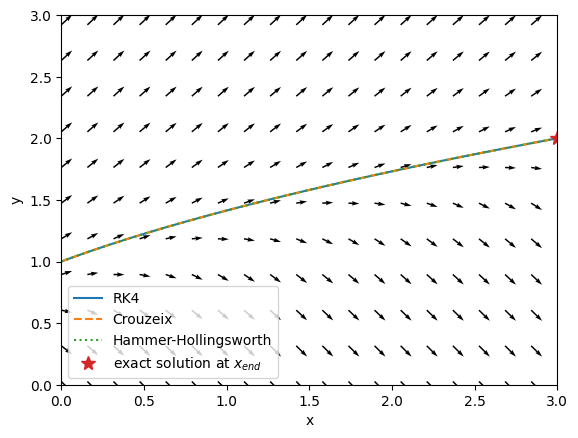

In [38]:
#parameters for the function

x_0 = 0.0 # start of interval
x_end = 3.0 # end of interval
h = 0.01 # step size
y0 = 1.0 # initial value of y

def f(x,y): # differential equation y' = f(x,y)
    return y - (1.0/y)*(0.5 + x) 
def df(x,y): # derivative of f with respect to y (needed for implicit methods)
    return 1.0 + (1.0/(y**2.0))*(0.5 + x)


# numerical solution with an ERK (explicit Runge-Kutta) method
x_RK4,y_RK4 = RK(x_0,x_end,h,y0,f,None,A_RK4,b_RK4,c_RK4)

# numerical solution with a DIRK (diagonally implicit Runge-Kutta) method
x_C,y_C = RK(x_0, x_end,h,y0,f,df,A_C,b_C,c_C)

# numerical solution with an IRK (fully implicit Runge-Kutta) method
x_HH,y_HH = RK(x_0, x_end,h,y0,f,df,A_HH,b_HH,c_HH)


# exact solution at x_end
y_end = 2.0


# plot slope field with normalized arrows
x = np.linspace(0.0,x_end,20)
y = np.linspace(-2.0,3.5,20)
X,Y = np.meshgrid(x,y)
U = 1.0
V = f(X,Y)
V = V/np.sqrt(U**2.0 + V**2.0)
plt.quiver(X,Y,U,V)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0.0,x_end])
plt.ylim([0.0, 3.0])

# add numerical solutions and exact solution to plot
plt.plot(x_RK4,y_RK4, label='RK4')
plt.plot(x_C,y_C, linestyle='dashed', label='Crouzeix')
plt.plot(x_HH,y_HH, linestyle='dotted', label='Hammer-Hollingsworth')
plt.plot(x_end,y_end,'*', markersize=10, label='exact solution at $x_{end}$')
plt.legend()
plt.show()

### Konvergenzordnung der Verfahren prüfen

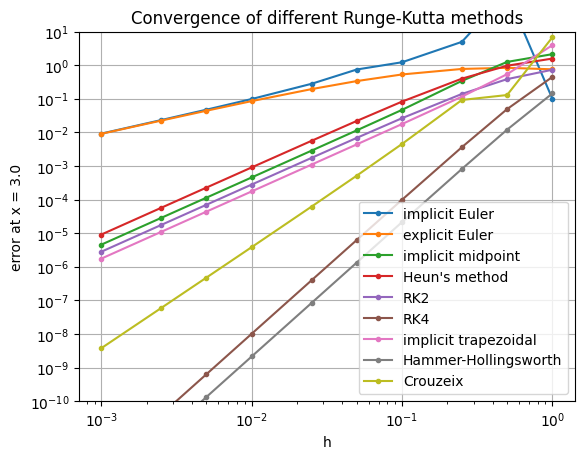

In [39]:
# check convergence of all methods with slope in log-log plot
"""
interpretation of slope:
    e = 1: first-order method
slope = 2: second-order method
slope = 3: third-order method
slope = 4: fourth-order method
"""

# define step sizes
hs = np.array([1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001])

# initialize arrays for errors
E_Ei = []
E_Ee = []
E_Mi = []
E_H = []
E_RK2 = []
E_RK4 = []
E_Ti = []
E_HH = []
E_C = []

# compute error of each method for all step sizes
for h in hs:
    
    # compute numerical solution with all methods
    x_Ei,y_Ei = RK(x0, x_end,h,y0,f,df,A_Ei,b_Ei,c_Ei)
    x_Ee,y_Ee = RK(x0, x_end,h,y0,f,df,A_Ee,b_Ee,c_Ee)
    x_Mi,y_Mi = RK(x0, x_end,h,y0,f,df,A_Mi,b_Mi,c_Mi)
    x_H,y_H = RK(x0,x_end,h,y0,f,df,A_H,b_H,c_H)
    x_RK2,y_RK2 = RK(x0,x_end,h,y0,f,df,A_RK2,b_RK2,c_RK2)
    x_RK4,y_RK4 = RK(x0,x_end,h,y0,f,df,A_RK4,b_RK4,c_RK4)
    x_Ti,y_Ti = RK(x0,x_end,h,y0,f,df,A_Ti,b_Ti,c_Ti)
    x_HH,y_HH = RK(x0,x_end,h,y0,f,df,A_HH,b_HH,c_HH)
    x_C,y_C = RK(x0,x_end,h,y0,f,df,A_C,b_C,c_C)

    # compute error at x = 3
    E_Ei.append(np.abs(y_Ei[-1] - y_end))
    E_Ee.append(np.abs(y_Ee[-1] - y_end))
    E_Mi.append(np.abs(y_Mi[-1] - y_end))
    E_H.append(np.abs(y_H[-1] - y_end))
    E_RK2.append(np.abs(y_RK2[-1] - y_end))
    E_RK4.append(np.abs(y_RK4[-1] - y_end))
    E_Ti.append(np.abs(y_Ti[-1] - y_end))
    E_HH.append(np.abs(y_HH[-1] - y_end))
    E_C.append(np.abs(y_C[-1] - y_end))


# plot errors
plt.figure()
plt.title('Convergence of different Runge-Kutta methods')

plt.loglog(hs,E_Ei,'.-',label='implicit Euler')
plt.loglog(hs,E_Ee,'.-',label='explicit Euler')
plt.loglog(hs,E_Mi,'.-',label='implicit midpoint')
plt.loglog(hs,E_H,'.-',label="Heun's method")
plt.loglog(hs,E_RK2,'.-',label='RK2')
plt.loglog(hs,E_RK4,'.-',label='RK4')
plt.loglog(hs,E_Ti,'.-',label='implicit trapezoidal')
plt.loglog(hs,E_HH,'.-',label='Hammer-Hollingsworth')
plt.loglog(hs,E_C,'.-',label='Crouzeix')

plt.xlabel('h')
plt.ylabel(f'error at x = {x_end}')
plt.xticks([1,0.1,0.01,0.001])
plt.yticks([1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10])
plt.ylim([1e-10,1e1])
plt.grid()
plt.legend()
plt.show()

# allgemeines RK-Verfahren für Systeme von ODE's
ERK (explicit) und DIRK (diagonally implicit) Butcher Tableaus können übergeben werden. FIRK (fully implicit) ist nicht vorgesehen, da nicht behandelt.

In [40]:
"""
description:
    solves a system of first order ODEs using a Runge-Kutta method specified by the Butcher tableau
    
params:
    x0: start point of the interval
    xend: end point of the interval
    h: step size
    y0: initial value
    f: function f(x,y) = y'
    Df: implicit methods require the Jacobian of f with respect to y (df(x,y)/dy), for explicit methods Df is not needed and can (but doesn't have to) be set to None
    A: matrix of Butcher tableau
    b: row vector at the bottom of Butcher tableau
    c: left-hand side of Butcher tableau

returns:
    x: array of x values with step size h
    y: array of corresponding y values
"""
def RK_Sys(x0, xend, h, y0, f, Df, A, b, c):
    n = len(y0)
    
    x = [x0]
    y = [y0]

    s = len(c) # number of stages
    r = np.array([f(x[-1],y[-1])]*s) # initialize slopes



    # if method is explicit (ERK), we can sequentially compute the slopes in each stage:
    if np.allclose(A,np.tril(A, -1)):

        # loop over all time steps
        while x[-1] < xend-h/2:
            # loop over stages
            for i in range(s):
                r[i] = f(x[-1]+c[i]*h, y[-1]+h*(A[i,:i]@r[:i]))
            y.append(y[-1]+h*b@r)
            x.append(x[-1]+h)


    # if method is diagonally implicit (DIRK), we can sequentially compute the slopes in each stage using Newton's method for systems of n equations.
    elif np.allclose(A,np.tril(A)):

        # function for Newton's method
        def g(ri, xk, yk):
            return ri - f(xk+c[i]*h, yk+h*(A[i,:i]@r[:i] + A[i,i]*ri))
        
        # derivative of g with respect to r
        def Dg(ri, xk, yk):
            return np.identity(n) - h*A[i,i]*Df(xk+c[i]*h, yk+h*(A[i,:i]@r[:i] + A[i,i]*ri))

        # Newton's method for DIRK
        def newton_vector(r, xk, yk, tol=1e-12, maxIter=20):
            k = 0
            delta = np.ones(n)*tol*10
            while np.linalg.norm(delta,np.inf) > tol and k < maxIter:
                J = Dg(r,xk,yk)
                res = g(r,xk,yk)
                P_T,L,R = sp.linalg.lu(J)
                z = sp.linalg.solve_triangular(L,P_T.T@res,lower=True)
                delta = sp.linalg.solve_triangular(R,z,lower=False)
                r = r - delta
            return r
        
        # loop over all time steps
        while x[-1] < xend-h/2:
            # loop over stages
            for i in range(s):
                r[i] = newton_vector(r[i], x[-1], y[-1]) # compute slope for stage i
            y.append(y[-1]+h*b@r)
            x.append(x[-1]+h)


    # if method is fully implicit (IRK), we would need to solve s*n equations in each time step => not implemented
    else:
        
        print('IRK not implemented')



    return np.array(x), np.array(y)

### Beispiele zu ERK (explizit), DIRK (diagonal implizit)

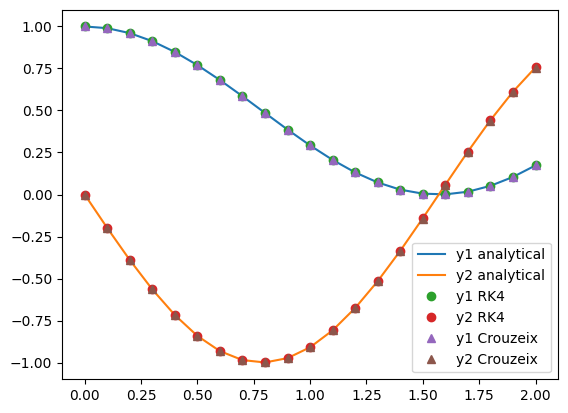

In [41]:
# parameters for the function

x_0 = 0.0 # start of interval
x_end = 2.0 # end of interval
h = 0.1 # step size
y0 = np.array([1.0,0.0]) # initial value of y

def f(x,y): # differential equation y' = f(x,y)
    return np.array([
        y[1],
        y[1]**2 + 4*y[0]*(y[0]-2) + 2
    ], dtype=float)

def Df(x,y): # Jacobian of f with respect to y (needed for implicit methods)
    return np.array([
        [0,1],
        [8*y[0]-8, 2*y[1]]
    ], dtype=float)


# numerical solution with an ERK (explicit Runge-Kutta) method
x_RK4,y_RK4 = RK_Sys(x_0,x_end,h,y0,f,None,A_RK4,b_RK4,c_RK4)

# numerical solution with a DIRK (diagonally implicit Runge-Kutta) method
x_C,y_C = RK_Sys(x_0, x_end,h,y0,f,Df,A_C,b_C,c_C)


# analytical solution
y1_an = lambda x: np.cos(x)**2
y2_an = lambda x: 2*np.cos(x)*(-np.sin(x))

# plot results
plt.plot(x_RK4, y1_an(x_RK4), label='y1 analytical')
plt.plot(x_RK4, y2_an(x_RK4), label='y2 analytical')
plt.plot(x_RK4, y_RK4[:,0], linestyle='none',marker='o', label='y1 RK4')
plt.plot(x_RK4, y_RK4[:,1], linestyle='none', marker='o',label='y2 RK4')
plt.plot(x_C, y_C[:,0], linestyle='none', marker='^', label='y1 Crouzeix')
plt.plot(x_C, y_C[:,1], linestyle='none', marker='^', label='y2 Crouzeix')
plt.legend()
plt.show()

### Konvergenzordnung der Verfahren prüfen

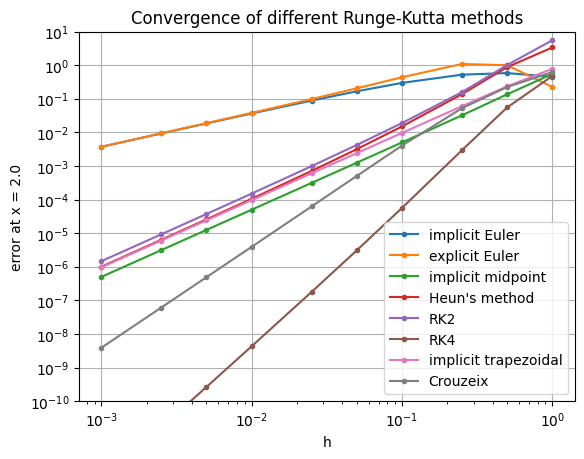

In [42]:
# check convergence of all methods with slope in log-log plot
"""
interpretation of slope:
slope = 1: first-order method
slope = 2: second-order method
slope = 3: third-order method
slope = 4: fourth-order method
"""

# define step sizes
hs = np.array([1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001])

# exact solution at x_end
y_an_end = np.array([y1_an(x_end), y2_an(x_end)])

# initialize arrays for errors
E_Ei = []
E_Ee = []
E_Mi = []
E_H = []
E_RK2 = []
E_RK4 = []
E_Ti = []
E_C = []


# compute error of each method for all step sizes
for h in hs:
    
    # compute numerical solution with all methods
    x_Ei,y_Ei = RK_Sys(x_0, x_end, h, y0, f, Df, A_Ei, b_Ei, c_Ei)
    x_Ee,y_Ee = RK_Sys(x_0, x_end, h, y0, f, None, A_Ee, b_Ee, c_Ee)
    x_Mi,y_Mi = RK_Sys(x_0, x_end, h, y0, f, Df, A_Mi, b_Mi, c_Mi)
    x_H,y_H = RK_Sys(x_0, x_end, h, y0, f, None, A_H, b_H, c_H)
    x_RK2,y_RK2 = RK_Sys(x_0, x_end, h, y0, f, None, A_RK2, b_RK2, c_RK2)
    x_RK4,y_RK4 = RK_Sys(x_0, x_end, h, y0, f, None, A_RK4, b_RK4, c_RK4)
    x_Ti,y_Ti = RK_Sys(x_0, x_end, h, y0, f, Df, A_Ti, b_Ti, c_Ti)
    x_C,y_C = RK_Sys(x_0, x_end, h, y0, f, Df, A_C, b_C, c_C)
    

    # compute error at x = 3
    E_Ei.append(np.abs(np.linalg.norm(y_Ei[-1]) - np.linalg.norm(y_an_end)))
    E_Ee.append(np.abs(np.linalg.norm(y_Ee[-1]) - np.linalg.norm(y_an_end)))
    E_Mi.append(np.abs(np.linalg.norm(y_Mi[-1]) - np.linalg.norm(y_an_end)))
    E_H.append(np.abs(np.linalg.norm(y_H[-1]) - np.linalg.norm(y_an_end)))
    E_RK2.append(np.abs(np.linalg.norm(y_RK2[-1]) - np.linalg.norm(y_an_end)))
    E_RK4.append(np.abs(np.linalg.norm(y_RK4[-1]) - np.linalg.norm(y_an_end)))
    E_Ti.append(np.abs(np.linalg.norm(y_Ti[-1]) - np.linalg.norm(y_an_end)))
    E_C.append(np.abs(np.linalg.norm(y_C[-1]) - np.linalg.norm(y_an_end)))


# plot errors
plt.figure()
plt.title('Convergence of different Runge-Kutta methods')

plt.loglog(hs,E_Ei,'.-',label='implicit Euler')
plt.loglog(hs,E_Ee,'.-',label='explicit Euler')
plt.loglog(hs,E_Mi,'.-',label='implicit midpoint')
plt.loglog(hs,E_H,'.-',label="Heun's method")
plt.loglog(hs,E_RK2,'.-',label='RK2')
plt.loglog(hs,E_RK4,'.-',label='RK4')
plt.loglog(hs,E_Ti,'.-',label='implicit trapezoidal')
plt.loglog(hs,E_C,'.-',label='Crouzeix')

plt.xlabel('h')
plt.ylabel(f'error at x = {x_end}')
plt.xticks([1,0.1,0.01,0.001])
plt.yticks([1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10])
plt.ylim([1e-10,1e1])
plt.grid()
plt.legend()
plt.show()

# kubische Splines

## natürliche Randbedingung

In [43]:
def cubic_natural_spline(x_values, y_values):

    # (konstante) Schrittweite
    h = x_values[1] - x_values[0]

    # Anzahl der Stützstellen
    m = len(x_values)

    # rechte Seite des linearen Gleichungssystems für die Momente aufstellen
    b = np.zeros(m-2)
    b = 6/h**2 * (y_values[:-2] - 2*y_values[1:-1] + y_values[2:])

    # Matrix A für das lineare Gleichungssystem aufstellen
    A = np.zeros((m-2, m-2))
    for i in range(m-3):
        A[i, i] = 4
        A[i, i+1] = 1
        A[i+1, i] = 1
    A[m-3, m-3] = 4

    # Momentenvektor initialisieren
    M = np.zeros(m)

    # natürliche Randbedingungen auf die äussersten Momente anwenden
    M[0] = M[m-1] = 0

    # LGS lösen
    L = sp.linalg.cholesky(A, lower=True) # Cholesky-Zerlegung
    y = sp.linalg.solve_triangular(L, b, lower=True) # Vorwärtseinsetzen    
    M[1:m-1] = sp.linalg.solve_triangular(L.T, y, lower=False) # Rückwärtseinsetzen

    # kubische Spline-Funktion definieren
    def s(x):
        
        # falls x ein Skalar ist
        if np.isscalar(x):

            # entsprechendes Teilintervall für x finden
            i = 0
            while (i < m-2) and (x_values[i+1] < x): # erste Abbruchbedingung verhindert allfälligen Indexüberlauf bei ungültigem x
                i += 1

            # Berechne die Funktion s_i(x) -> in der folgenden Zeile steht die eigentliche Berechnung von s für das Teilintervall i
            y = (M[i] * (x_values[i+1] - x)**3 + M[i+1] * (x - x_values[i])**3) / (6*h) + ((y_values[i] - M[i]*h**2/6) * (x_values[i+1] - x) + (y_values[i+1] - M[i+1]*h**2/6) * (x - x_values[i])) / h
        
        # falls x ein Array ist, muss s() (rekursiv) für alle Elemente in x aufgerufen werden ("list comprehension")
        else:
            y = np.array([s(val) for val in x])  # s auf jedes Element von x anwenden
        
        return y 
    

    return s # die natürliche Splinefunktion s() zurückgeben

### Beispiel

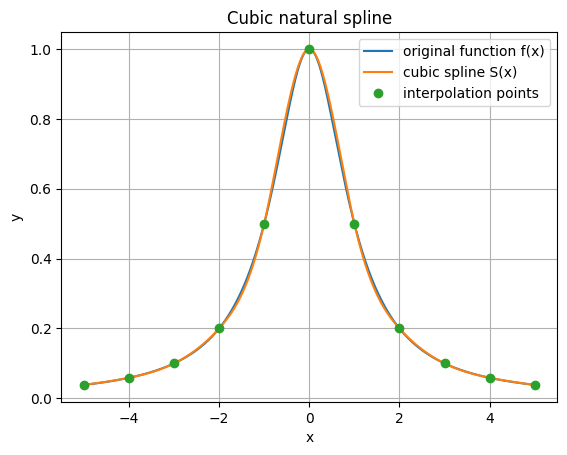

In [44]:
# create knots for the interpolation
def f(x):
    return 1 / (1 + x**2)
x_values = np.linspace(-5, 5, 11)
y_values = f(x_values)

# use cubic natural spline function
cns = cubic_natural_spline(x_values, y_values)

# plot the function and the interpolation points as well as the spline
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, f(xs), label='original function f(x)')
plt.plot(xs, cns(xs), label='cubic spline S(x)')
plt.plot(x_values, y_values, 'o', label='interpolation points')
plt.legend()
plt.title(f'Cubic natural spline')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True) 
plt.show()

## periodische Randbedingungen

In [45]:
def cubic_periodic_spline(x_values, y_values):
    
    # (konstante) Schrittweite
    h = x_values[1] - x_values[0]

    # Anzahl der Stützstellen
    m = len(x_values)

    # rechte Seite des linearen Gleichungssystems für die Momente aufstellen
    b = (6/h**2) * (4*y_values[0:m-2] - 8*y_values[1:m-1] + 4*y_values[2:m])
    b[0] += (6/h**2) * ((y_values[m-1] - y_values[m-2]) -  (y_values[1] - y_values[0]))
    b[-1] +=  (6/h**2) * ((y_values[m-1] - y_values[m-2]) - (y_values[1] - y_values[0]))

    # Matrix A für das lineare Gleichungssystem aufstellen
    A = np.zeros((m-2, m-2))
    A[0, 0] = 15
    A[0, 1] = 4
    A[0, m-3] = -1
    for i in range(1, m-3): 
        A[i,i-1] = 4
        A[i,i] = 16
        A[i,i+1] = 4
    A[m-3, 0] = -1
    A[m-3, m-4] = 4
    A[m-3, m-3] = 15

    # Momentenvektor initialisieren
    M = np.zeros(m)

    # LGS lösen
    L = sp.linalg.cholesky(A, lower=True) # Cholesky-Zerlegung
    y = sp.linalg.solve_triangular(L, b, lower=True) # Vorwärtseinsetzen    
    M[1:m-1] = sp.linalg.solve_triangular(L.T, y, lower=False) # Rückwärtseinsetzen

    # periodische Randbedingungen auf die äussersten Momente anwenden
    M[0] = M[m-1] = 3/(2*h) * ( (y_values[1]-y_values[0])/h - (y_values[m-1]-y_values[m-2])/h - h/6*M[1] - h/6*M[m-2] )

    # kubische Spline-Funktion definieren
    def s(x):
        
        # falls x ein Skalar ist
        if np.isscalar(x):

            # entsprechendes Teilintervall für x finden
            i = 0
            while (i < m-2) and (x_values[i+1] < x): # erste Abbruchbedingung verhindert allfälligen Indexüberlauf bei ungültigem x
                i += 1

            # Berechne die Funktion s_i(x) -> in der folgenden Zeile steht die eigentliche Berechnung von s für das Teilintervall i
            y = (M[i] * (x_values[i+1] - x)**3 + M[i+1] * (x - x_values[i])**3) / (6*h) + ((y_values[i] - M[i]*h**2/6) * (x_values[i+1] - x) + (y_values[i+1] - M[i+1]*h**2/6) * (x - x_values[i])) / h
        
        # falls x ein Array ist, muss s() (rekursiv) für alle Elemente in x aufgerufen werden ("list comprehension")
        else:
            y = np.array([s(val) for val in x])  # s auf jedes Element von x anwenden
        
        return y 
    

    return s # die periodische Splinefunktion s() zurückgeben

### Beispiel

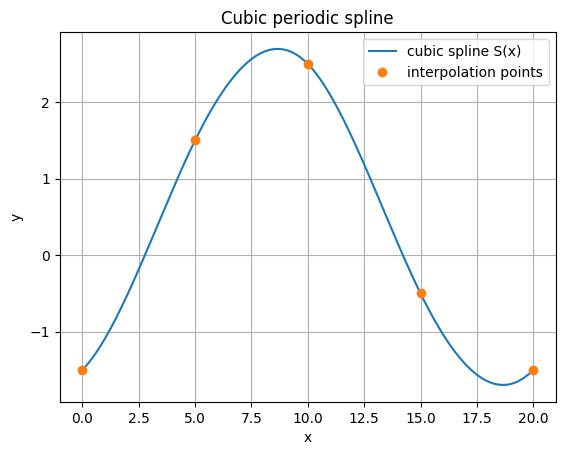

In [46]:
# knots for interpolation
t = np.array([0, 5, 10, 15, 20], dtype=float)
u = np.array([-1.5, 1.5, 2.5, -0.5, -1.5])

# use cubic periodic spline function
cps = cubic_periodic_spline(t, u) 

# plot the function and the interpolation points as well as the spline
ts = np.linspace(0, 20, 1000)
plt.plot(ts, cps(ts), label='cubic spline S(x)')
plt.plot(t, u, 'o', label='interpolation points')
plt.legend()
plt.title(f'Cubic periodic spline')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True) 
plt.show()

#Example adjusting butcher tableau


None


ValueError: x, y, and format string must not be None

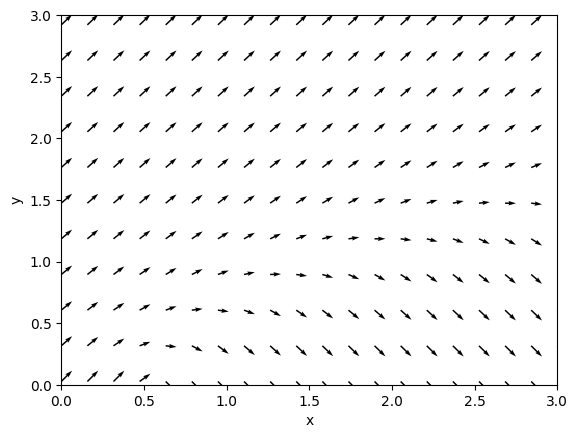

In [59]:
A_RK4 = np.array([[0.0, 0.0, 0.0, 0.0],
                [1/2, 0.0, 0.0, 0.0],
                [0.0, 1/2, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0]], dtype=float)
b_RK4 = np.array([1/6, 1/3, 1/3, 1/6], dtype=float)
c_RK4 = np.array([0.0, 1/2, 1/2, 1.0], dtype=float)


def RK(x0, xend, h, y0, f, df, A, b, c):
    x = [x0]
    y = [y0]

    s = len(c) # number of stages
    id = np.eye(s) # identity matrix of size s
    r = np.array([f(x[-1],y[-1])]*s) # initialize slopes



    # if method is explicit (ERK), we can sequentially compute the slopes in each stage:
    if np.allclose(A,np.tril(A, -1)):

        # loop over all time steps
        while x[-1] < xend-h/2:
            # loop over stages
            for i in range(s):
                r[i] = f(x[-1]+c[i]*h, y[-1]+h*(A[i,:i]@r[:i]))
            y.append(y[-1]+h*r@b)
            x.append(x[-1]+h)


    # if method is diagonally implicit (DIRK), we can sequentially compute the slopes in each stage using scalar Newton's method:
    elif np.allclose(A,np.tril(A)):

        # function for Newton's method
        def g(ri, xk, yk):
            res = ri - f(xk+c[i]*h, yk+h*(A[i,:i]@r[:i] + A[i,i]*ri))
            return res
        
        # derivative of g with respect to r
        def dg(ri, xk, yk):
            res = 1 - h*A[i,i]*df(xk+c[i]*h, yk+h*(A[i,:i]@r[:i] + A[i,i]*ri))
            return res

        # Newton's method for DIRK
        def newton_scalar(r, xk, yk, tol=1e-12, maxIter=20):
            k = 0
            delta = 10 * tol
            while np.abs(delta) > tol and k < maxIter:
                delta = g(r,xk,yk) / dg(r,xk,yk)
                r = r - delta
                k += 1
            return r
        
        # loop over all time steps
        while x[-1] < xend-h/2:
            # loop over stages
            for i in range(s):
                r[i] = newton_scalar(r[i], x[-1], y[-1]) # compute slope for stage i
            y.append(y[-1]+h*r@b)
            x.append(x[-1]+h)


    # if method is fully implicit (IRK), we need to solve a system of equations in each time step:
    else:
        
        # function for Newton's method
        def G(r, xk, yk):
            res = np.zeros(s) # residual vector 
            # loop over stages
            for i in range(s):
                res[i] = r[i] - f(xk+c[i]*h, yk+h*(A[i,:]@r)) # compute residual for stage i
            return res

        

#def RK(x0, xend, h, y0, f, df, A, b, c):


x_0 = 0.0 # start of interval
x_end = 3.0 # end of interval
N = 30
h = (xend - x0) / N
y0 = 1.0 # initial value of y



def f(x,y): # differential equation y' = f(x,y)
    return y+(0.5-x)/y 
def df(x,y): # derivative of f with respect to y (needed for implicit methods)
    return 1+(0.5+x)/(y**2)




# numerical solution with an ERK (explicit Runge-Kutta) method
y_RK4 = RK(x_0,x_end,h,y0,f,df,A_RK4,b_RK4,c_RK4)
print(y_RK4)

# numerical solution with a DIRK (diagonally implicit Runge-Kutta) method
#y_C = RK(x_0, x_end,h,y0,f,df,A_C,b_C,c_C)

# numerical solution with an IRK (fully implicit Runge-Kutta) method
#y_HH = RK(x_0, x_end,h,y0,f,df,A_HH,b_HH,c_HH)


# exact solution at x_end
y_end = 2.0


# plot slope field with normalized arrows
x = np.linspace(0.0,x_end,20)
y = np.linspace(-2.0,3.5,20)
X,Y = np.meshgrid(x,y)
U = 1.0
V = f(X,Y)
V = V/np.sqrt(U**2.0 + V**2.0)
plt.quiver(X,Y,U,V)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0.0,x_end])
plt.ylim([0.0, 3.0])

# add numerical solutions and exact solution to plot
x_RK4 = np.linspace(x_0, x_end, N+1)
plt.plot(x_RK4,y_RK4)
#plt.plot(x_C,y_C, linestyle='dashed', label='Crouzeix')
#plt.plot(x_HH,y_HH, linestyle='dotted', label='Hammer-Hollingsworth')
#plt.plot(x_end,y_end,'*', markersize=10, label='exact solution at $x_{end}$')
plt.legend()
plt.show()


